# Initial codes

This notebook illustrates how Bayesian inference can be used to infer response rates of each group (basket) in a Basket trial.

In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import sys
from os.path import exists

sys.path.append('..')
sys.path.append('.')

In [3]:
import numpy as np
import pandas as pd
import arviz as az

In [4]:
from pyBasket.env import Trial

In [5]:
DEBUG = True

In [6]:
num_burn_in = 1E5
num_posterior_samples = 1E5
num_chains = None # let pymc decide

In [7]:
if DEBUG:
    num_burn_in = 1E4
    num_posterior_samples = 1E4
    num_chains = 1

## Example 1: treatment is of interest in all groups

Same example as in [Berry et al. 2013](https://journals.sagepub.com/doi/full/10.1177/1740774513497539) (Figure 1).

4 groups are present in the trial, and all group response rates to the treatment are the same (0.3). The trial enrolls patients in 6 stages, first taking 10 patient for each group in the first stage, followed by 5 patients for each group in latter stages.

> The first example is a scenario in which responses are simulated assuming p = 30% in all four groups. This example illustrates the effect of borrowing across groups when all groups are similar, such as the smoothing of the observed response rates and a reduction in uncertainty.

### Generate data

In [8]:
K = 4    # the number of groups
p0 = 0.1 # null response rate
p1 = 0.3 # target response rate

true_response_rates = [p1, p1, p1, p1]
enrollment = [10, 5, 5, 5, 5, 5]

evaluate_interim = [True, True, True, True, True, True] # evaluate every interim stage
model_names = ['independent', 'hierarchical', 'bhm']

In [9]:
trial = Trial(K, p0, p1, true_response_rates, enrollment, evaluate_interim, 
              num_burn_in, num_posterior_samples, model_names, num_chains=num_chains)

done = trial.reset()
while not done:
    done = trial.step()


########## Stage=0 Enrolled = 10 ##########
Group 0 (true θ=0.30) [0, 0, 0, 0, 0, 0, 1, 1, 0, 0]
Group 1 (true θ=0.30) [0, 0, 1, 1, 0, 1, 1, 0, 0, 0]
Group 2 (true θ=0.30) [1, 1, 0, 0, 0, 0, 0, 0, 0, 0]
Group 3 (true θ=0.30) [1, 0, 0, 0, 0, 0, 0, 1, 0, 1]


model_name independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 7 seconds.


,prob,futile,effective
k,,,
0,0.6136,False,False
1,0.9481,False,True
2,0.6182,False,False
3,0.8436,False,False



model_name hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 16 seconds.


,prob,futile,effective
k,,,
0,0.7881,False,False
1,0.9442,False,True
2,0.7744,False,False
3,0.8780,False,False



model_name bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 14 seconds.


,prob,futile,effective
k,,,
0,0.5632,False,False
1,0.9388,False,True
2,0.5484,False,False
3,0.8067,False,False



########## Stage=1 Enrolled = 15 ##########
Group 0 (true θ=0.30) [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0]
Group 1 (true θ=0.30) [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1]
Group 2 (true θ=0.30) [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 3 (true θ=0.30) [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1]


model_name independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 7 seconds.


,prob,futile,effective
k,,,
0,0.8005,False,False
1,0.9727,False,True
2,0.3551,False,False
3,0.9237,False,True



model_name hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 16 seconds.


,prob,futile,effective
k,,,
0,0.8702,False,False
1,0.9694,False,True
2,0.6275,False,False
3,0.9291,False,True



model_name bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 14 seconds.


,prob,futile,effective
k,,,
0,0.7637,False,False
1,0.9687,False,True
2,0.2809,False,False
3,0.9052,False,True



########## Stage=2 Enrolled = 20 ##########
Group 0 (true θ=0.30) [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1]
Group 1 (true θ=0.30) [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Group 2 (true θ=0.30) [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0]
Group 3 (true θ=0.30) [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]


model_name independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 7 seconds.


,prob,futile,effective
k,,,
0,0.8941,False,False
1,0.9859,False,True
2,0.5858,False,False
3,0.8915,False,False



model_name hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 17 seconds.


,prob,futile,effective
k,,,
0,0.9301,False,True
1,0.9852,False,True
2,0.7756,False,False
3,0.9313,False,True



model_name bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 14 seconds.


,prob,futile,effective
k,,,
0,0.8786,False,False
1,0.9849,False,True
2,0.5506,False,False
3,0.8786,False,False



########## Stage=3 Enrolled = 25 ##########
Group 0 (true θ=0.30) [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1]
Group 1 (true θ=0.30) [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]
Group 2 (true θ=0.30) [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1]
Group 3 (true θ=0.30) [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]


model_name independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 7 seconds.


,prob,futile,effective
k,,,
0,0.9740,False,True
1,0.9453,False,True
2,0.5775,False,False
3,0.7492,False,False



model_name hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 17 seconds.


,prob,futile,effective
k,,,
0,0.9797,False,True
1,0.9547,False,True
2,0.7387,False,False
3,0.8451,False,False



model_name bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 14 seconds.


,prob,futile,effective
k,,,
0,0.9700,False,True
1,0.9296,False,True
2,0.5300,False,False
3,0.7134,False,False



########## Stage=4 Enrolled = 30 ##########
Group 0 (true θ=0.30) [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0]
Group 1 (true θ=0.30) [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 2 (true θ=0.30) [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]
Group 3 (true θ=0.30) [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


model_name independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 7 seconds.


,prob,futile,effective
k,,,
0,0.9859,False,True
1,0.8486,False,False
2,0.7311,False,False
3,0.7367,False,False



model_name hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 17 seconds.


,prob,futile,effective
k,,,
0,0.9871,False,True
1,0.8999,False,False
2,0.8216,False,False
3,0.8198,False,False



model_name bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 14 seconds.


,prob,futile,effective
k,,,
0,0.9847,False,True
1,0.8295,False,False
2,0.7017,False,False
3,0.6849,False,False



########## Stage=5 Enrolled = 35 ##########
Group 0 (true θ=0.30) [0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0]
Group 1 (true θ=0.30) [0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 2 (true θ=0.30) [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1]
Group 3 (true θ=0.30) [1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0]


model_name independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 7 seconds.


,prob,futile,effective
k,,,
0,1.0000,None,True
1,0.9927,None,True
2,0.9989,None,True
3,0.9968,None,True



model_name hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 17 seconds.


,prob,futile,effective
k,,,
0,1.0000,None,True
1,0.9985,None,True
2,1.0000,None,True
3,0.9995,None,True



model_name bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 14 seconds.


,prob,futile,effective
k,,,
0,1.0000,None,True
1,0.9874,None,True
2,0.9992,None,True
3,0.9963,None,True


### Check last results

### Independent

In [10]:
model_name = model_names[0]
model_name

'independent'

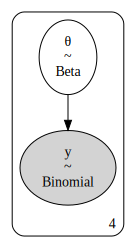

In [11]:
trial.visualise_model(model_name)

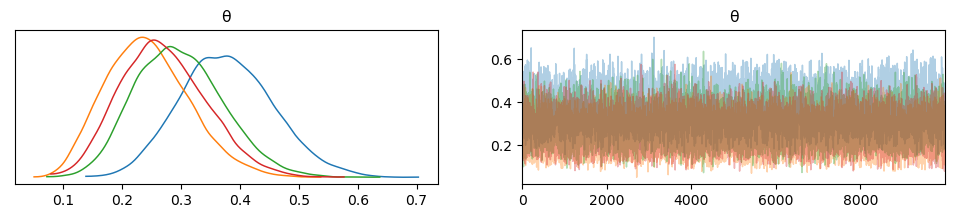

In [12]:
trial.plot_trace(model_name, -1)

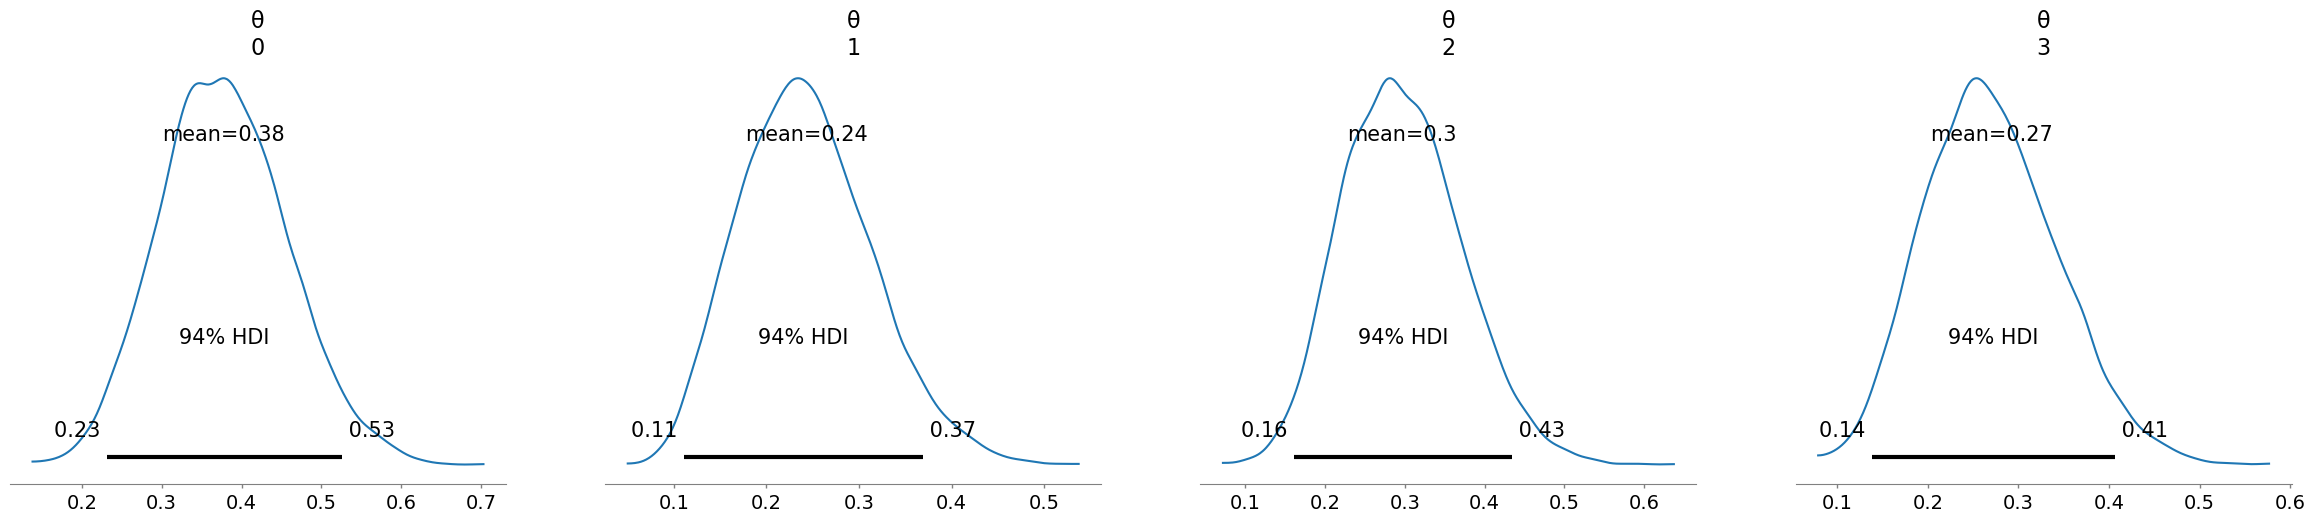

In [13]:
trial.plot_posterior(model_name, -1)

### Hierarchical

In [14]:
model_name = model_names[1]

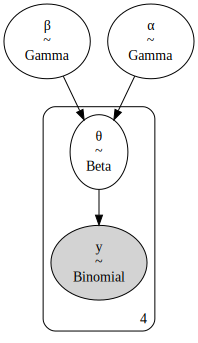

In [15]:
trial.visualise_model(model_name)

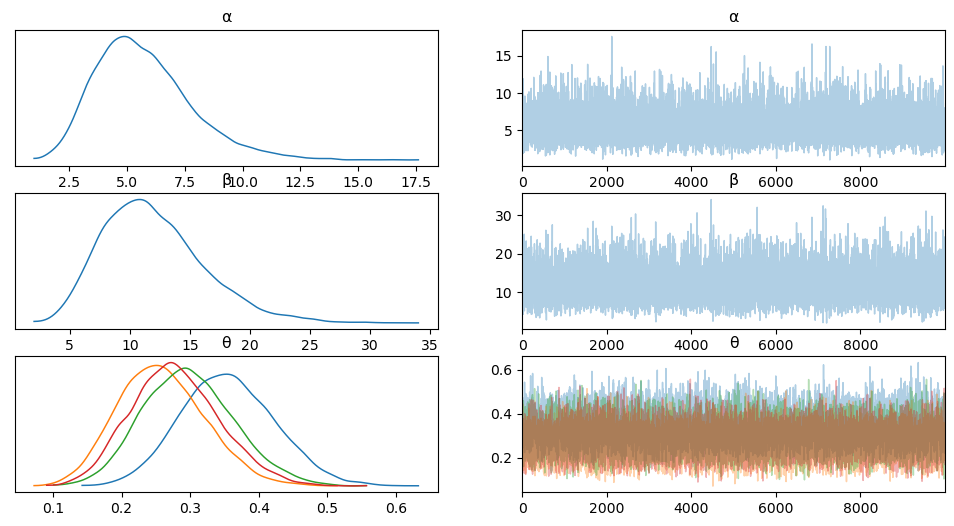

In [16]:
trial.plot_trace(model_name, -1)

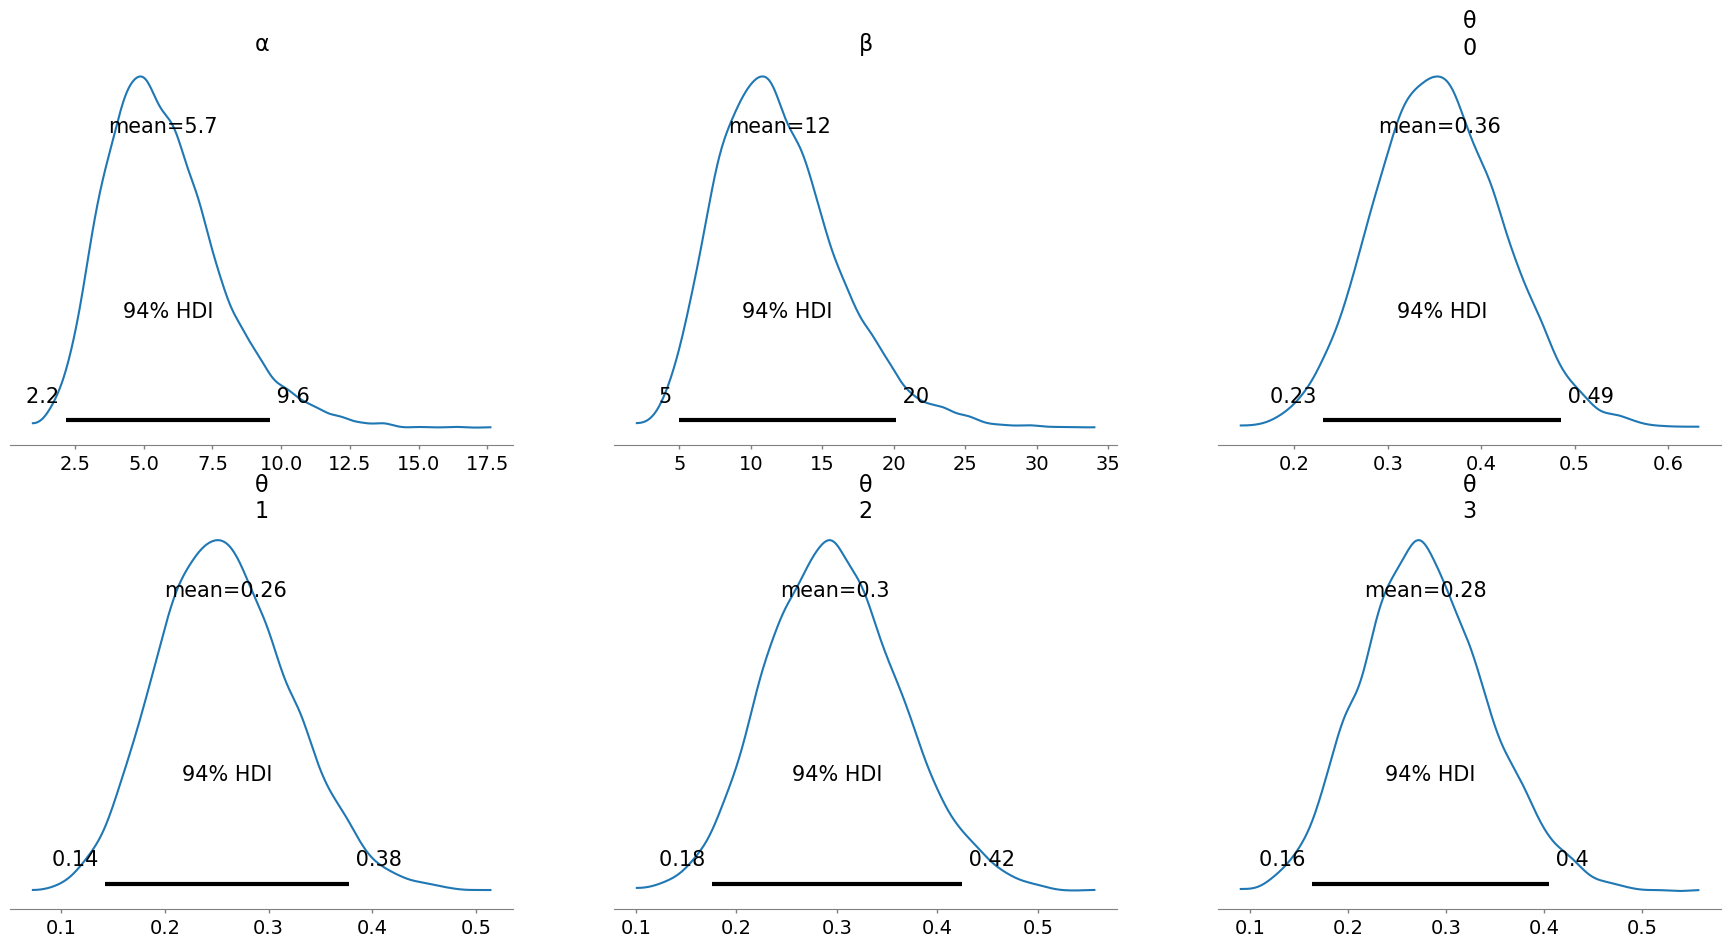

In [17]:
trial.plot_posterior(model_name, -1)

### BHM

In [18]:
model_name = model_names[2]

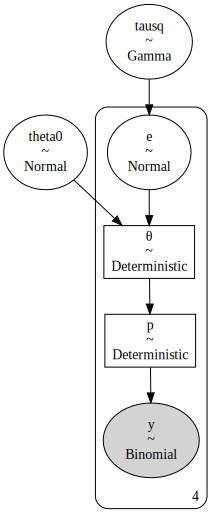

In [19]:
trial.visualise_model(model_name)

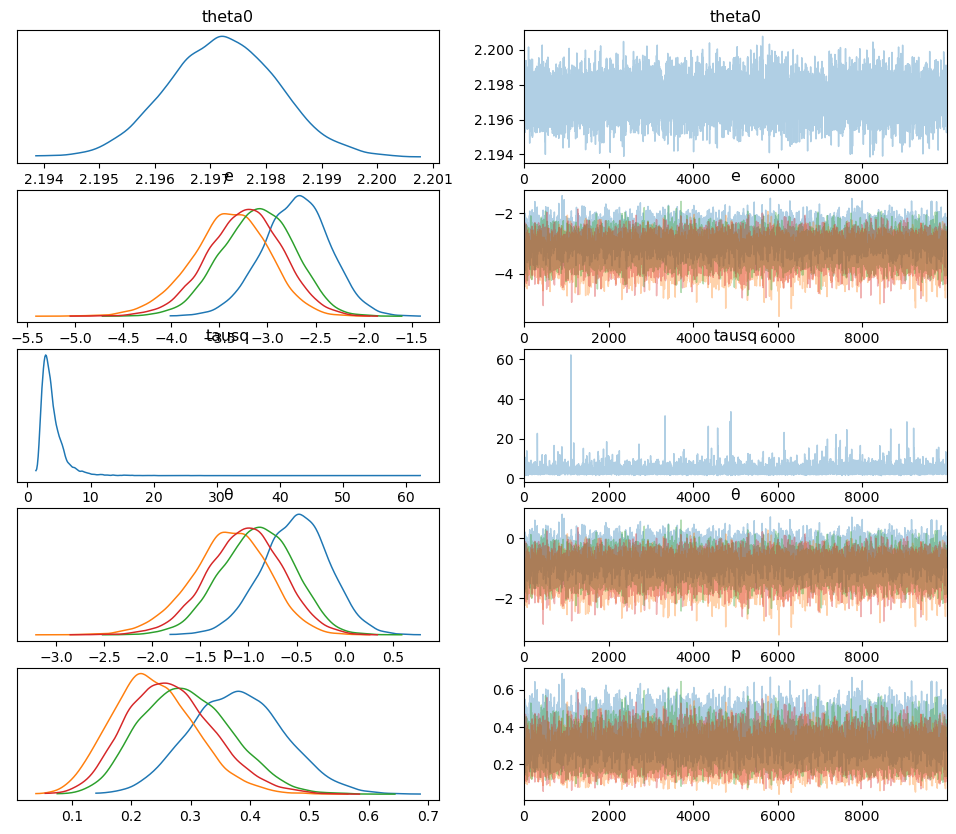

In [20]:
trial.plot_trace(model_name, -1)

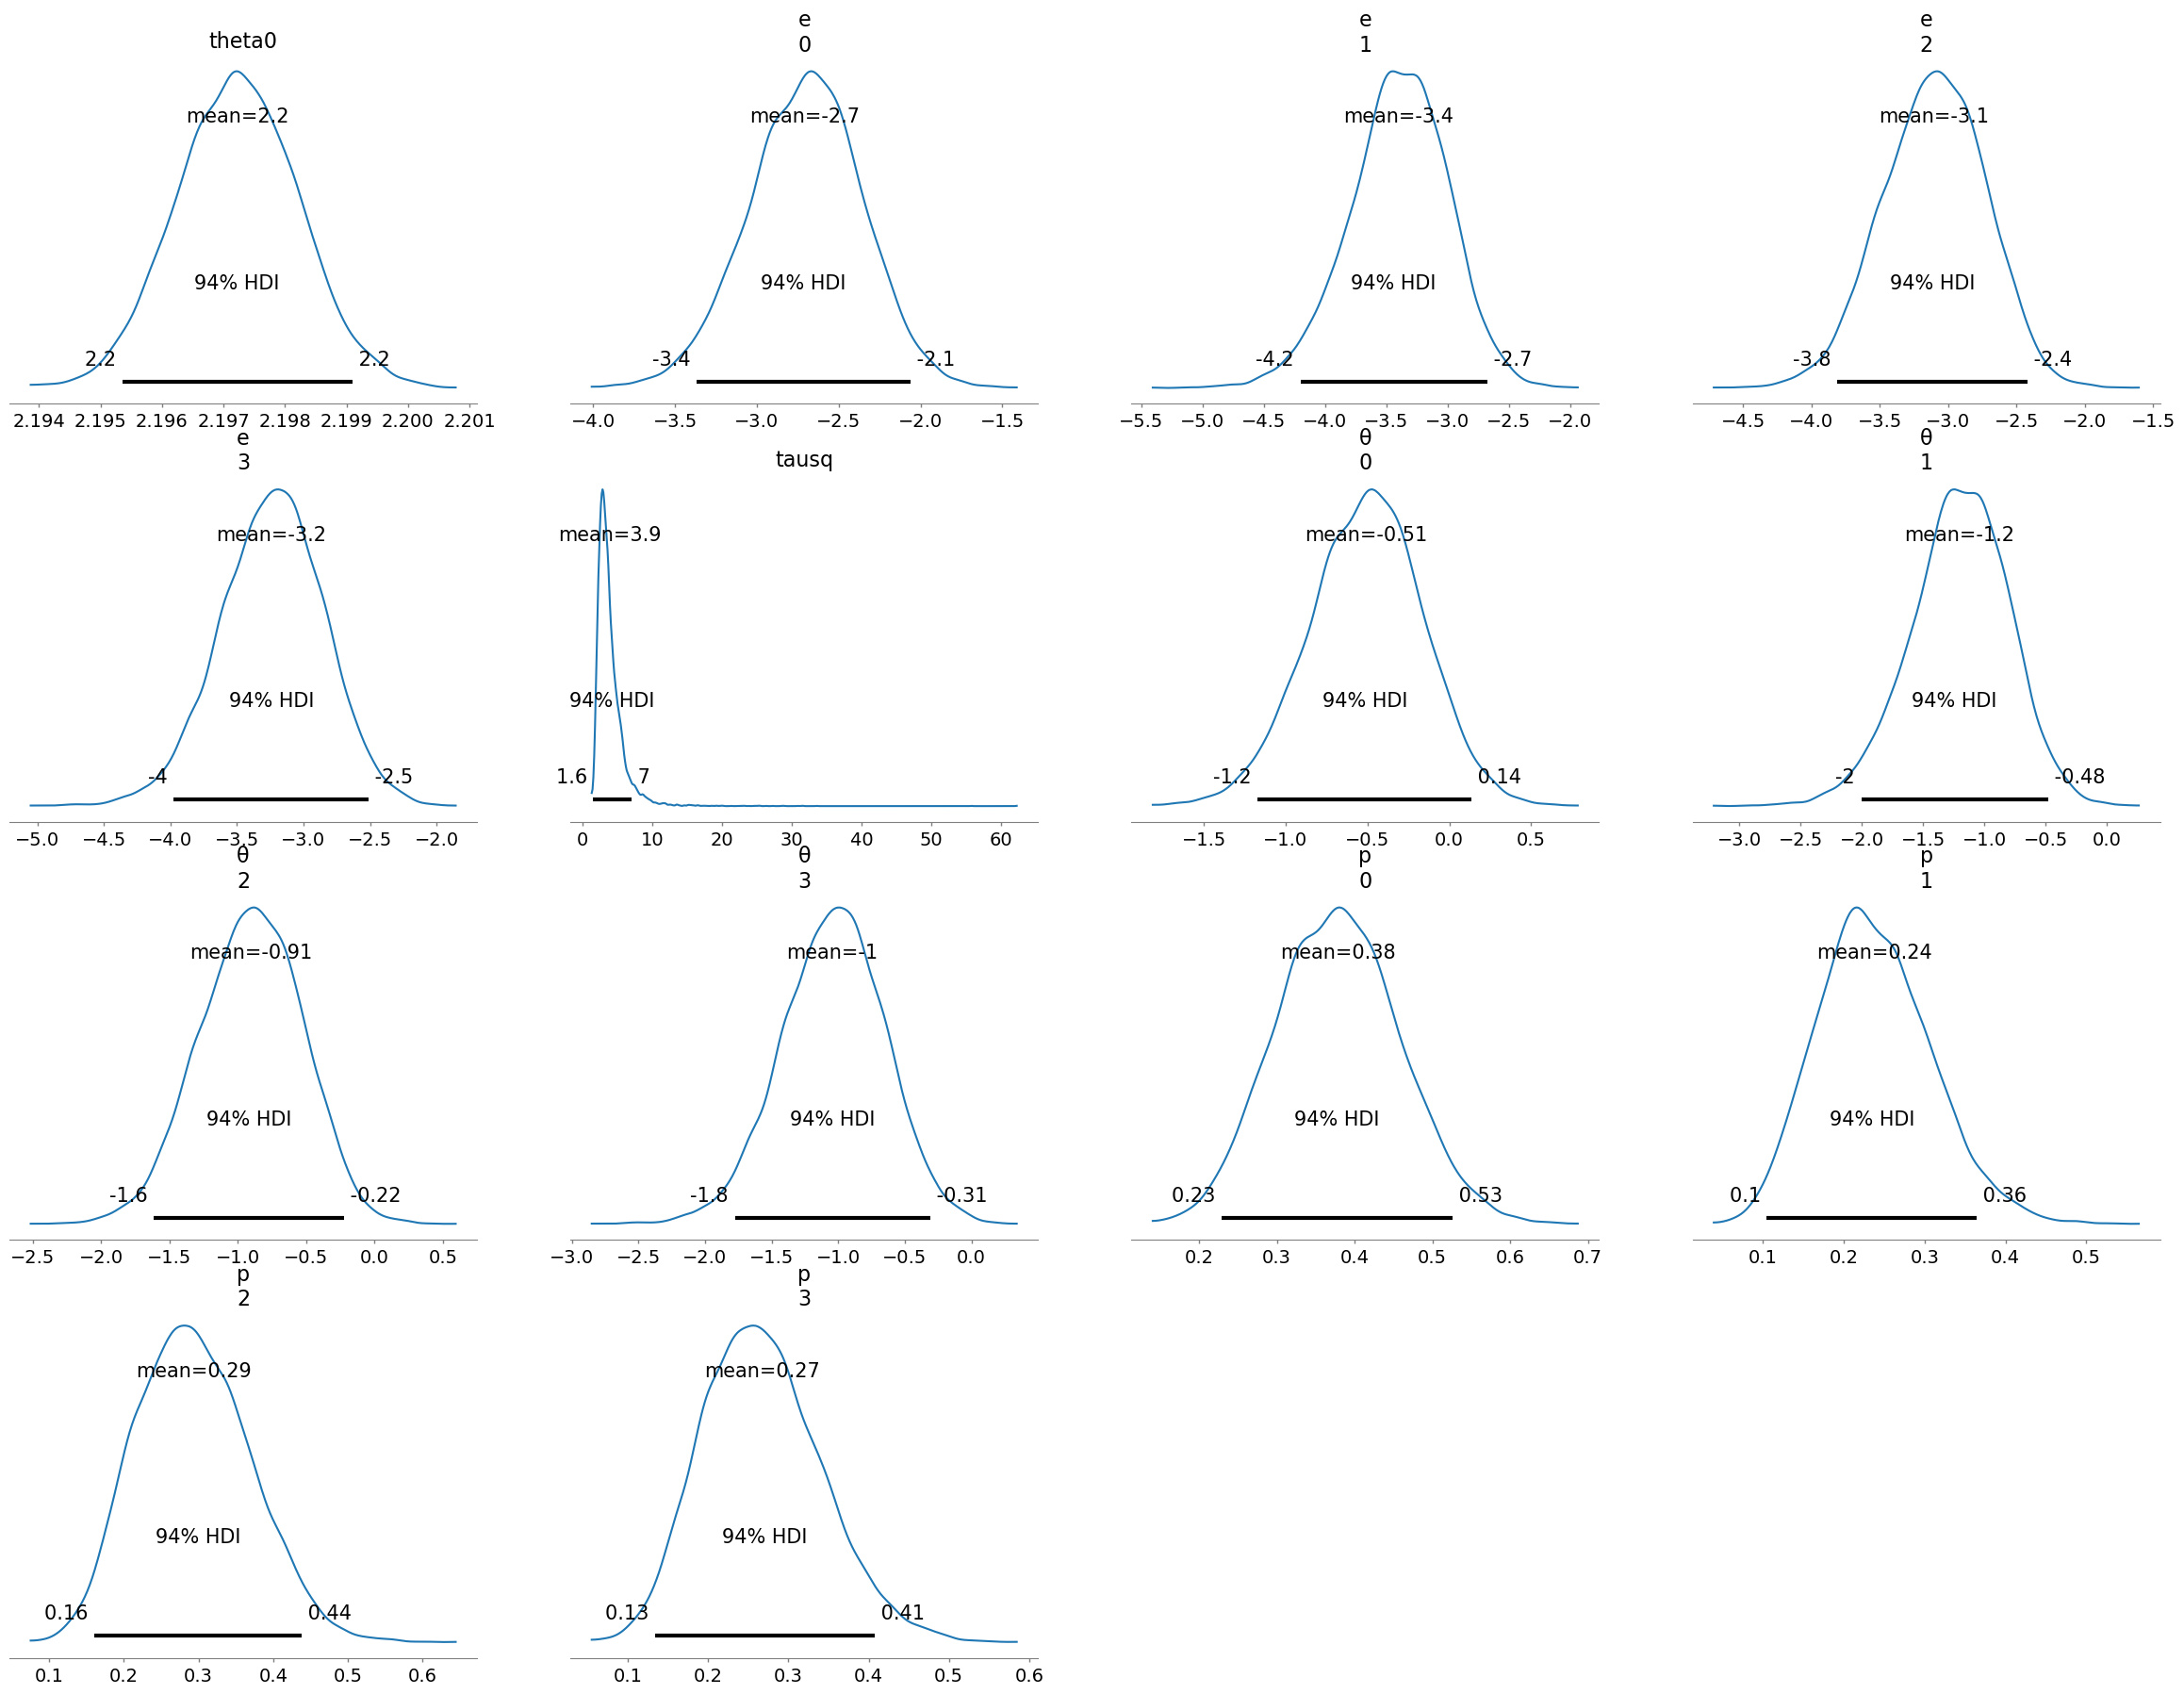

In [21]:
trial.plot_posterior(model_name, -1)

## Example 2: treatment is of interest in only two groups

Same example as in [Berry et al. 2013](https://journals.sagepub.com/doi/full/10.1177/1740774513497539) (Figure 2).

4 groups are present in the group, with first two group responses = 0.10 and the other two groups = 0.3. The trial enrolls patients in 6 stages, first taking 10 patient for each group in the first stage, followed by 5 patients for each group in latter stages.

> The second example is from a scenario in which responses are simulated assuming p = 10% in two groups and p = 30% in two groups. This example illustrates the effect of borrowing, and that the harm is not great, when groups are dissimilar.

### Generate data

In [22]:
K = 4    # the number of groups
p0 = 0.1 # null response rate
p1 = 0.3 # target response rate

true_response_rates = [p0, p0, p1, p1]
enrollment = [10, 5, 5, 5, 5, 5]

evaluate_interim = [True, True, True, True, True, True] # evaluate every interim stage
model_names = ['independent', 'hierarchical', 'bhm']

In [ ]:
trial = Trial(K, p0, p1, true_response_rates, enrollment, evaluate_interim, 
              num_burn_in, num_posterior_samples, model_names, num_chains=num_chains)

done = trial.reset()
while not done:
    done = trial.step()


########## Stage=0 Enrolled = 10 ##########
Group 0 (true θ=0.10) [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Group 1 (true θ=0.10) [0, 0, 1, 1, 0, 0, 0, 0, 0, 1]
Group 2 (true θ=0.30) [1, 0, 0, 0, 1, 0, 0, 0, 0, 1]
Group 3 (true θ=0.30) [0, 0, 1, 1, 0, 0, 1, 1, 1, 0]


model_name independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 7 seconds.


,prob,futile,effective
k,,,
0,0.3208,False,False
1,0.8385,False,False
2,0.8363,False,False
3,0.9888,False,True



model_name hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 17 seconds.


,prob,futile,effective
k,,,
0,0.6713,False,False
1,0.9041,False,True
2,0.8982,False,False
3,0.9805,False,True



model_name bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 15 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


,prob,futile,effective
k,,,
0,0.2442,False,False
1,0.8101,False,False
2,0.8075,False,False
3,0.9898,False,True



########## Stage=1 Enrolled = 15 ##########
Group 0 (true θ=0.10) [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Group 1 (true θ=0.10) [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Group 2 (true θ=0.30) [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0]
Group 3 (true θ=0.30) [0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1]


model_name independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 7 seconds.


,prob,futile,effective
k,,,
0,0.1391,False,False
1,0.6018,False,False
2,0.9150,False,True
3,0.9926,False,True



model_name hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 17 seconds.


,prob,futile,effective
k,,,
0,0.4101,False,False
1,0.7229,False,False
2,0.9132,False,True
3,0.9853,False,True



model_name bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 15 seconds.


,prob,futile,effective
k,,,
0,0.0938,False,False
1,0.5273,False,False
2,0.8944,False,False
3,0.9931,False,True



########## Stage=2 Enrolled = 20 ##########
Group 0 (true θ=0.10) [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 1 (true θ=0.10) [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 2 (true θ=0.30) [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0]
Group 3 (true θ=0.30) [0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0]


model_name independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 8 seconds.


,prob,futile,effective
k,,,
0,0.0608,False,False
1,0.3746,False,False
2,0.9603,False,True
3,0.9861,False,True



model_name hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 17 seconds.


,prob,futile,effective
k,,,
0,0.2126,False,False
1,0.5051,False,False
2,0.9368,False,True
3,0.9710,False,True



model_name bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 15 seconds.


,prob,futile,effective
k,,,
0,0.0327,True,False
1,0.2911,False,False
2,0.9474,False,True
3,0.9832,False,True



########## Stage=3 Enrolled = 25 ##########
Group 0 (true θ=0.10) [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Group 1 (true θ=0.10) [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 2 (true θ=0.30) [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]
Group 3 (true θ=0.30) [0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]


model_name independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 7 seconds.


,prob,futile,effective
k,,,
0,0.0806,False,False
1,0.2096,False,False
2,0.9392,False,True
3,0.9765,False,True



model_name hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 16 seconds.


,prob,futile,effective
k,,,
0,0.1969,False,False
1,0.3194,False,False
2,0.9155,False,True
3,0.9535,False,True



model_name bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 14 seconds.


,prob,futile,effective
k,,,
0,0.0555,False,False
1,0.1493,False,False
2,0.9314,False,True
3,0.9701,False,True



########## Stage=4 Enrolled = 30 ##########
Group 0 (true θ=0.10) [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
Group 1 (true θ=0.10) [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 2 (true θ=0.30) [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1]
Group 3 (true θ=0.30) [0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1]


model_name independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 7 seconds.


,prob,futile,effective
k,,,
0,0.0386,True,False
1,0.1059,False,False
2,0.9865,False,True
3,0.9871,False,True



model_name hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 16 seconds.


,prob,futile,effective
k,,,
0,0.1071,False,False
1,0.1975,False,False
2,0.9749,False,True
3,0.9683,False,True



model_name bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 15 seconds.


,prob,futile,effective
k,,,
0,0.0201,True,False
1,0.0706,False,False
2,0.9864,False,True
3,0.9827,False,True



########## Stage=5 Enrolled = 35 ##########
Group 0 (true θ=0.10) [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 1 (true θ=0.10) [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Group 2 (true θ=0.30) [1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0]
Group 3 (true θ=0.30) [0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0]


model_name independent


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 7 seconds.


,prob,futile,effective
k,,,
0,0.2978,None,False
1,0.5073,None,False
2,0.9999,None,True
3,1.0000,None,True



model_name hierarchical


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [α, β, θ]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 16 seconds.


,prob,futile,effective
k,,,
0,0.5269,None,False
1,0.6936,None,False
2,0.9998,None,True
3,1.0000,None,True



model_name bhm


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [tausq, theta0, e]


Sampling 1 chain for 10_000 tune and 10_000 draw iterations (10_000 + 10_000 draws total) took 15 seconds.


,prob,futile,effective
k,,,
0,0.1868,None,False
1,0.3985,None,False
2,0.9999,None,True
3,1.0000,None,True


### Check last results

### Independent

In [ ]:
model_name = model_names[0]

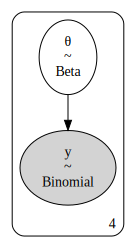

In [ ]:
trial.visualise_model(model_name)

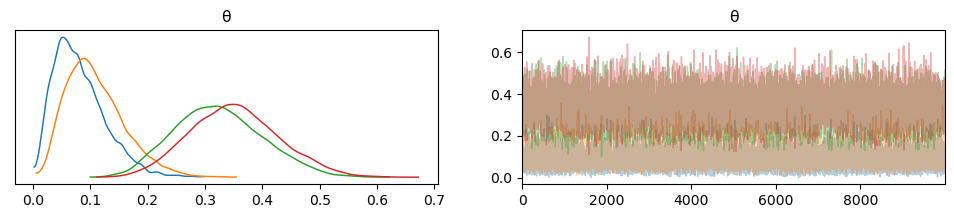

In [ ]:
trial.plot_trace(model_name, -1)

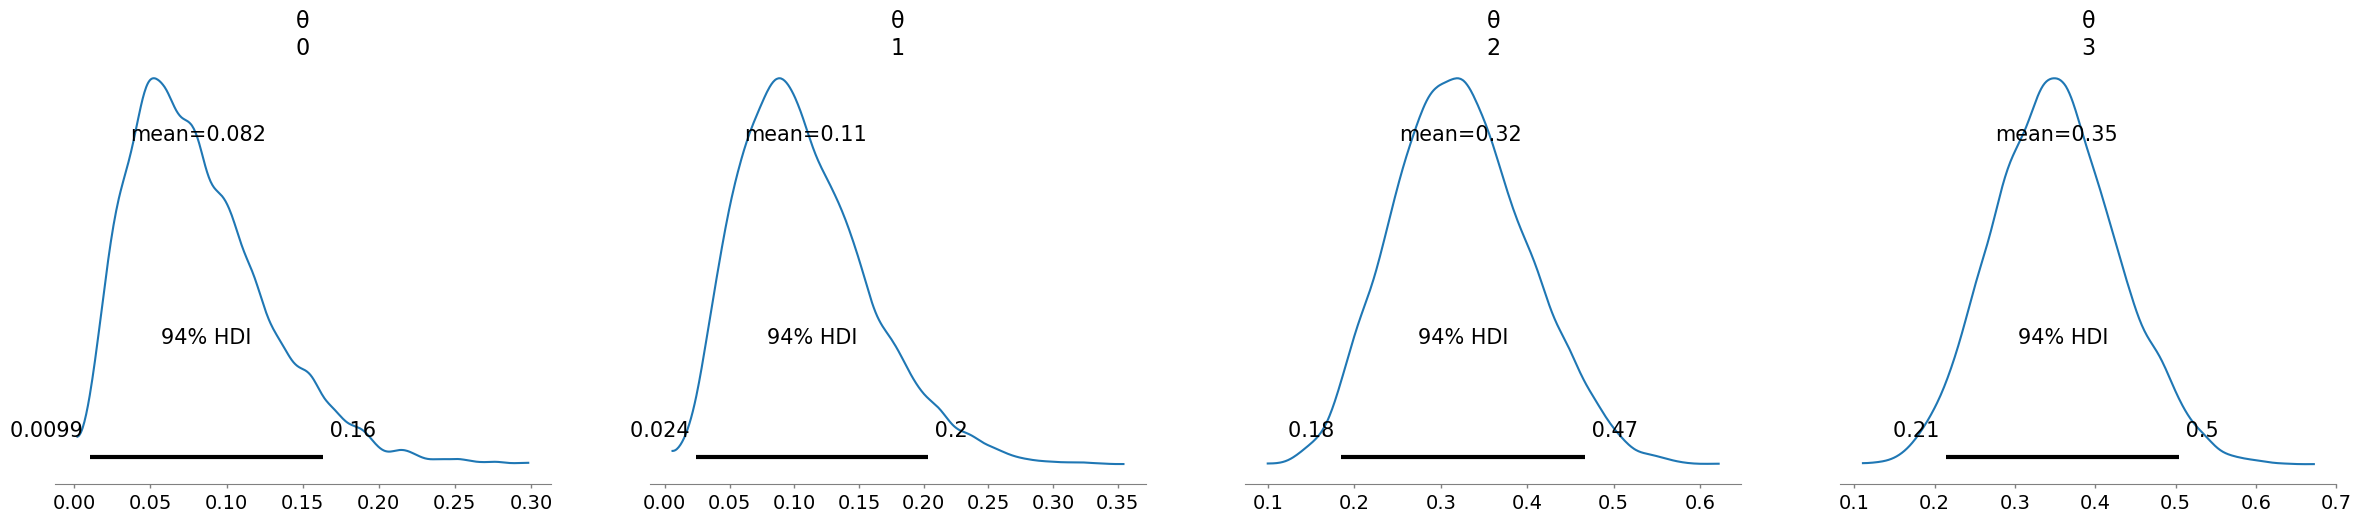

In [ ]:
trial.plot_posterior(model_name, -1)

### Hierarchical

In [ ]:
model_name = model_names[1]

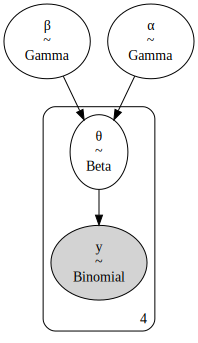

In [ ]:
trial.visualise_model(model_name)

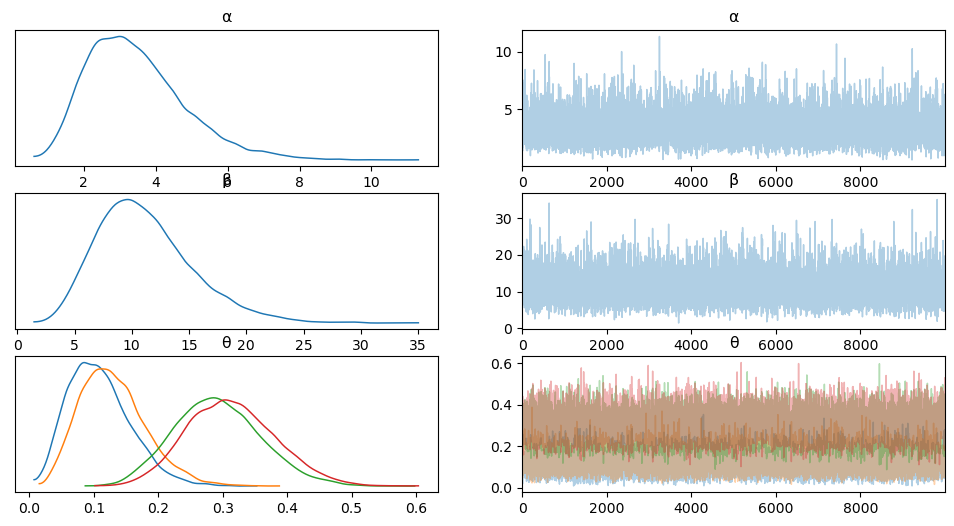

In [ ]:
trial.plot_trace(model_name, -1)

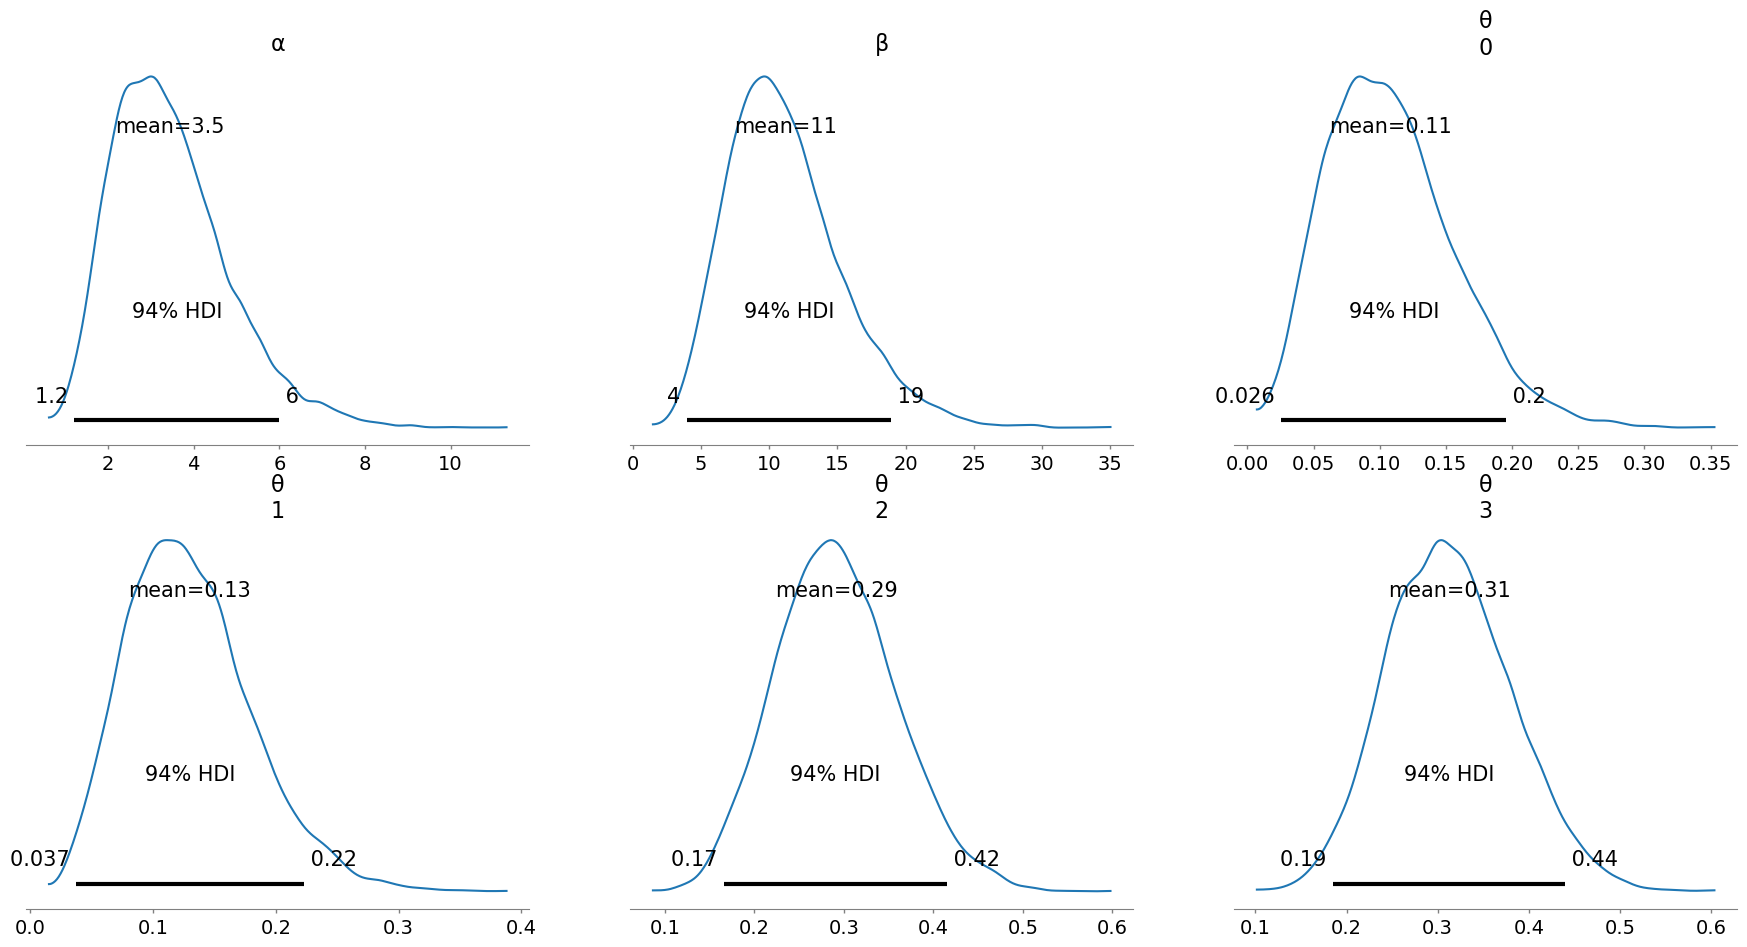

In [ ]:
trial.plot_posterior(model_name, -1)

### BHM

In [ ]:
model_name = model_names[2]

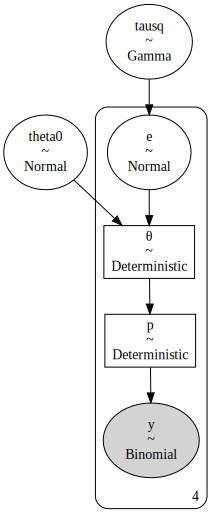

In [ ]:
trial.visualise_model(model_name)

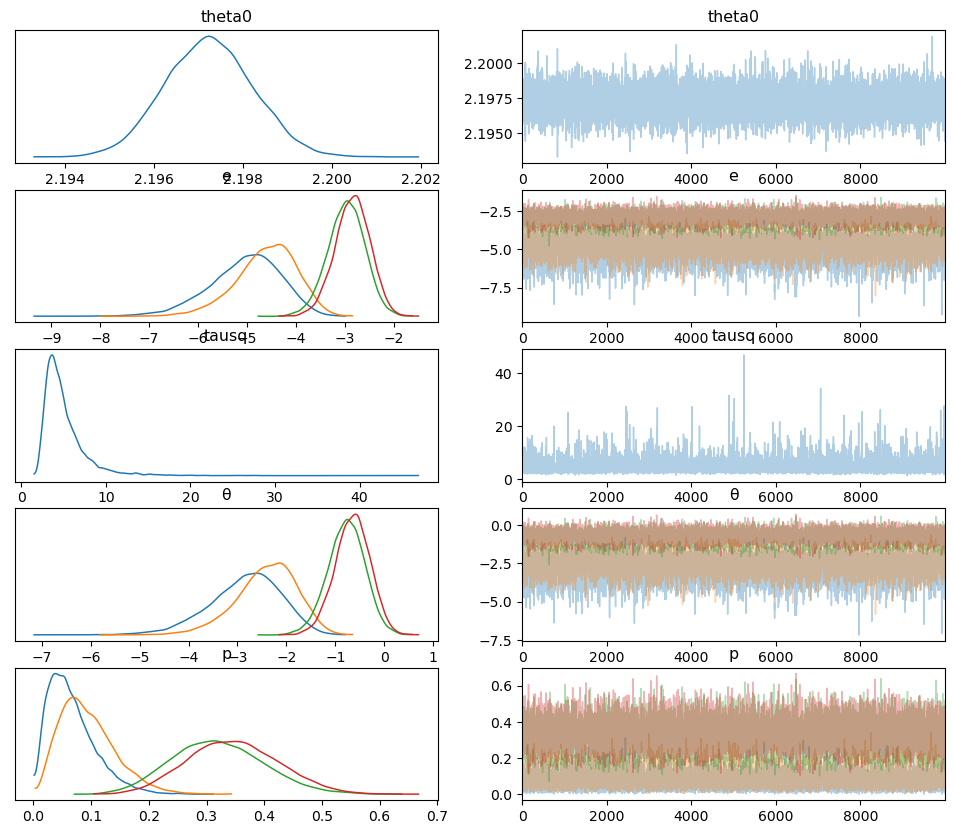

In [ ]:
trial.plot_trace(model_name, -1)

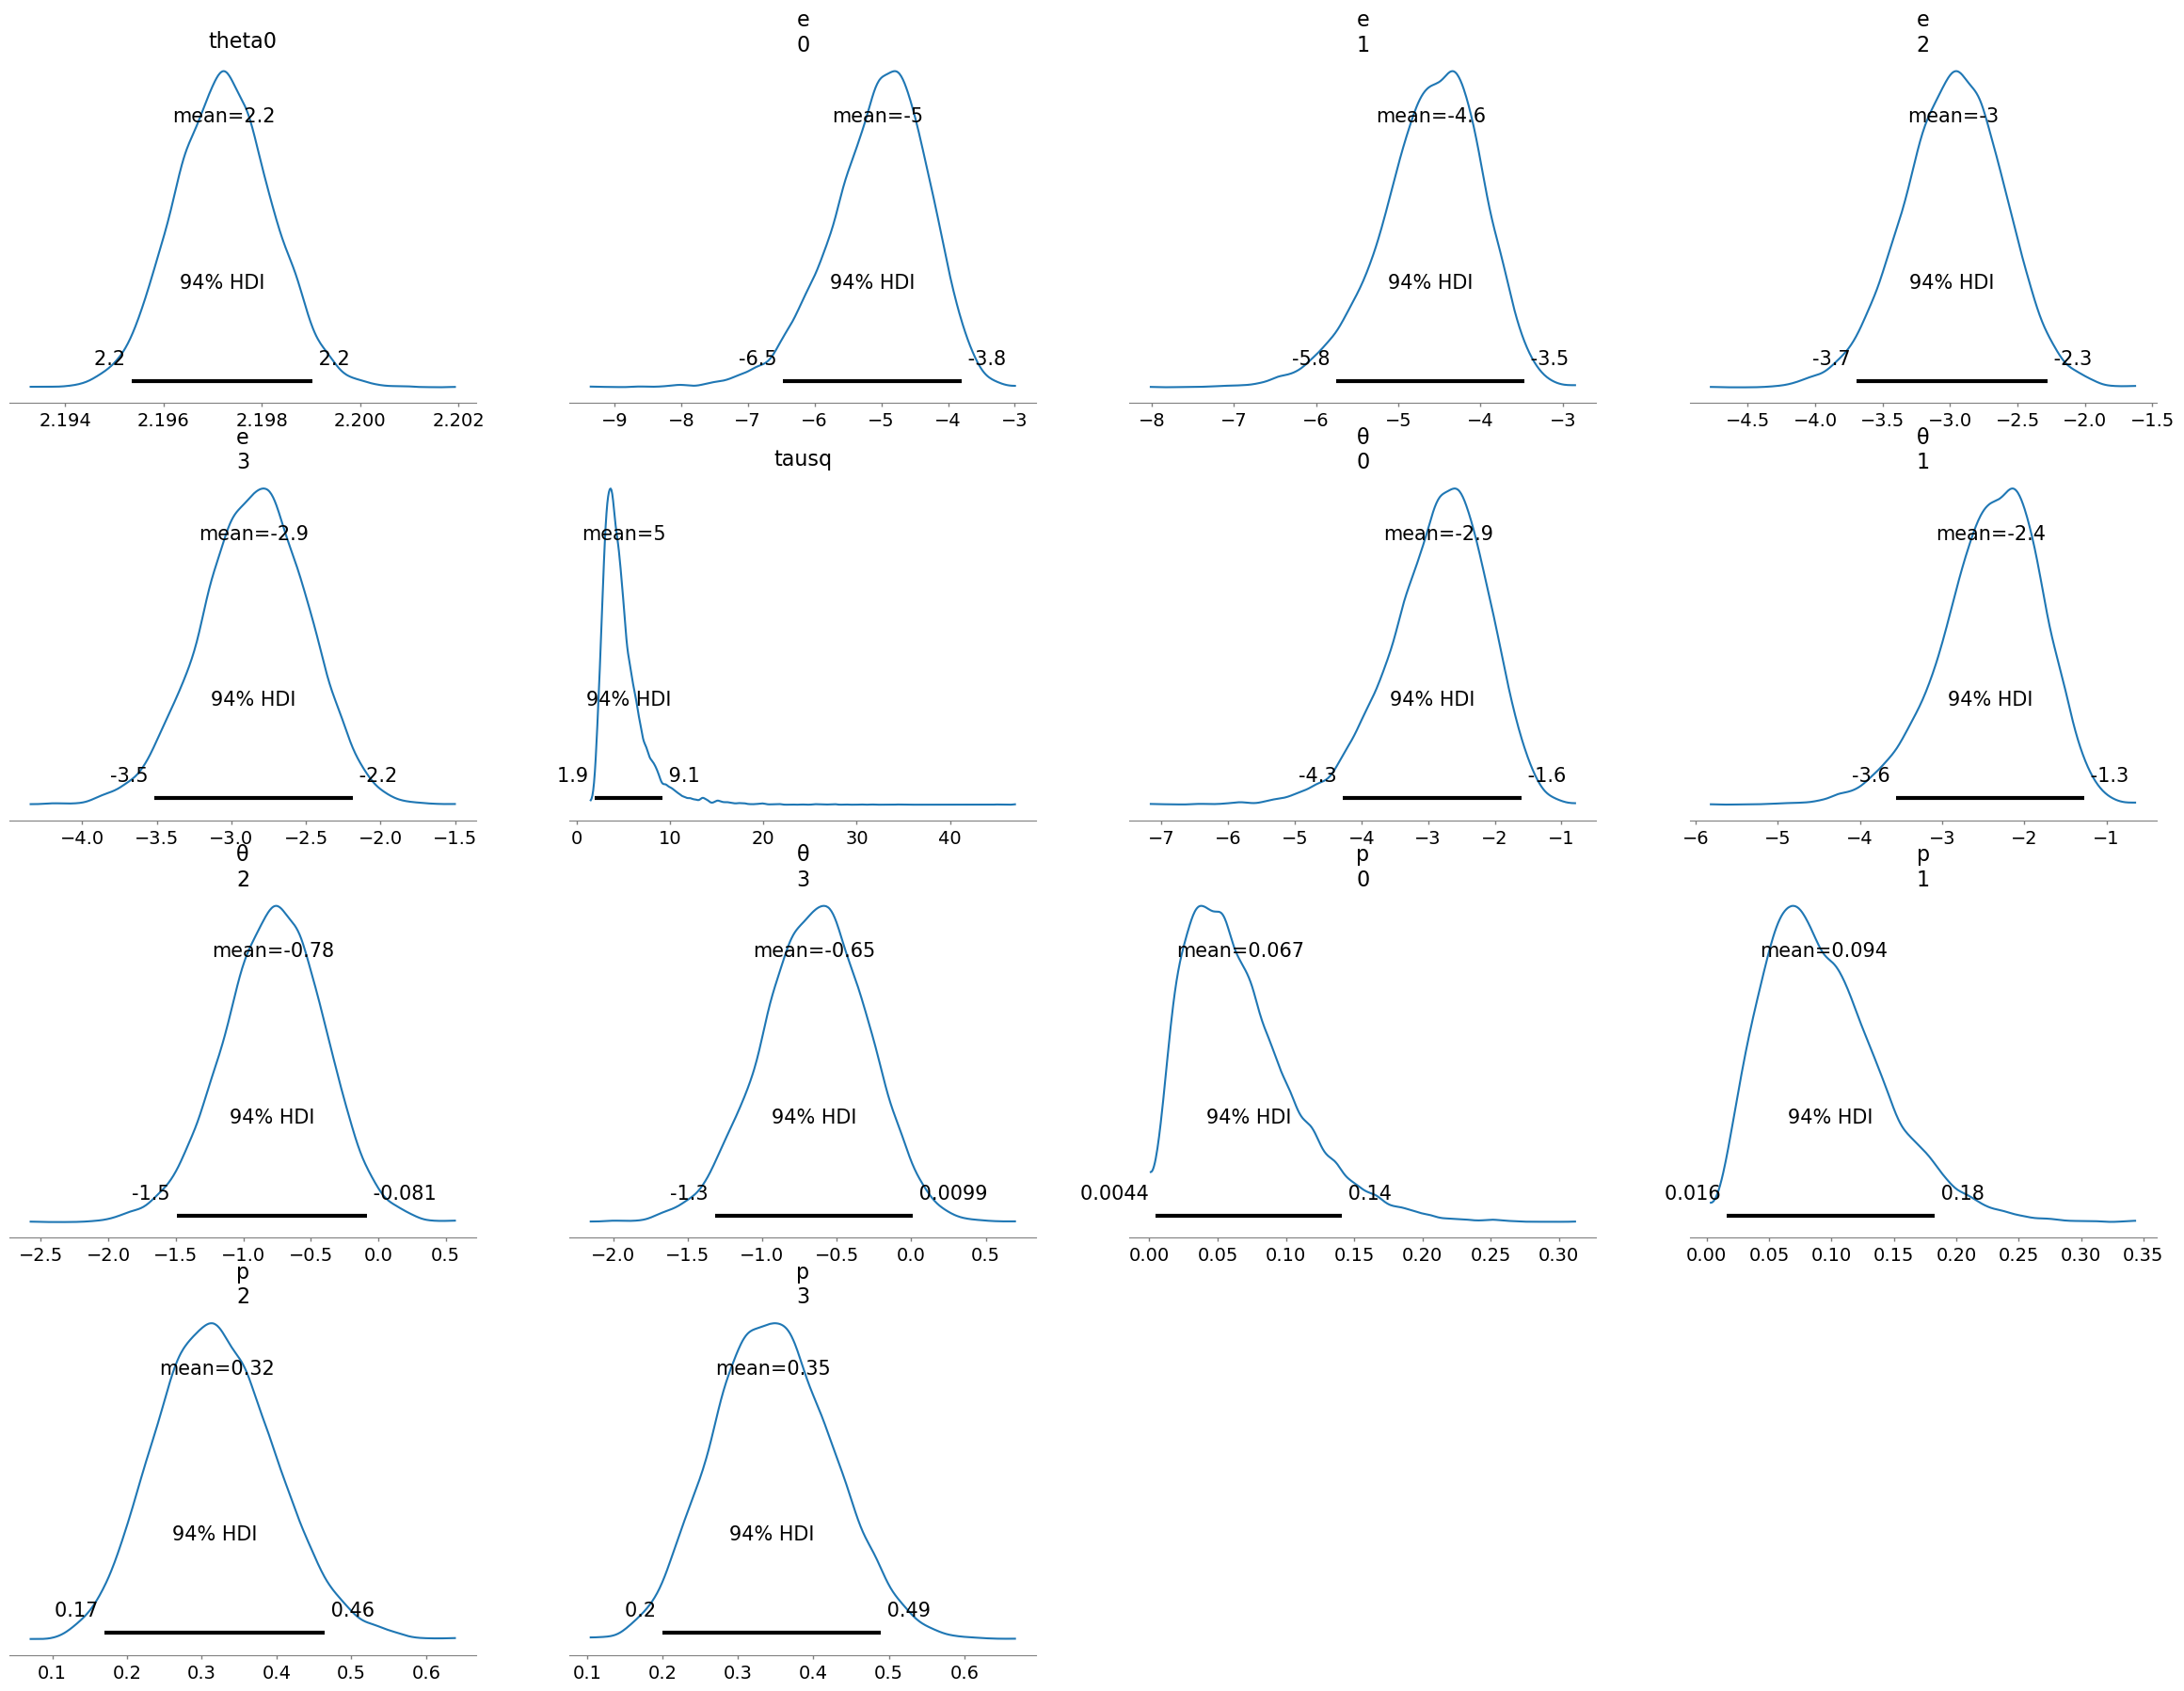

In [ ]:
trial.plot_posterior(model_name, -1)